In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# A more powerful package: pyGAM

pyGAM is a python package that is designed specifically for GAM. It is more powerful and includes more variations of models and smoothers. For example:

1. LinearGAM identity link and normal distribution
2. LogisticGAM logit link and binomial distribution
3. PoissonGAM log link and Poisson distribution
4. GammaGAM log link and gamma distribution
5. InvGauss log link and inv_gauss distribution

https://pygam.readthedocs.io/en/latest/

# Linear GAM with 1 Variable

### For a dataset with only 1 column of x, this is like normal non-linear regression with Splines

In [2]:
from pygam import LinearGAM
from pygam import LinearGAM, s, f, l, te    # import the LinearGAM, s, f, l, te functions
from pygam.datasets import mcycle  # import the mcycle dataset

X, y = mcycle(return_X_y=True)     # load the mcycle dataset, return_X_y=True: returns the predictors and response
print('X shape\n', X.shape)
print('y shape\n', y.shape)

X shape
 (133, 1)
y shape
 (133,)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


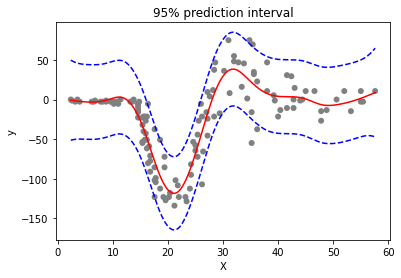

In [3]:
term = s(0,n_splines=20)
gam = LinearGAM(term)      # create the LinearGAM object
gam.gridsearch(X, y)               # grid search to find the best penalty

XX = gam.generate_X_grid(term=0, n=500)   # generate the grid for the term 0(first term), and there is only one term in this model
plt.plot(XX, gam.predict(XX), 'r-')      # plot the prediction
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')  # plot the 95% prediction interval

plt.scatter(X, y, facecolor='gray', edgecolors='none') # scatter plot
plt.title('95% prediction interval') 
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [4]:
gam.summary()  # print the summary of the model

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.8135
Link Function:                     IdentityLink Log Likelihood:                                  -952.2409
Number of Samples:                          133 AIC:                                             1930.1088
                                                AICc:                                            1933.0789
                                                GCV:                                              609.3811
                                                Scale:                                            512.7965
                                                Pseudo R-Squared:                                   0.7984
Feature Function                  Lam

# Linear GAM with Multiple Variables

In [5]:
from pygam import LinearGAM, s, f, l, te    # import the LinearGAM, s, f, l, te functions
from pygam.datasets import wage         # import the wage dataset

X, y = wage(return_X_y=True)            # load the wage dataset, return_X_y=True: returns the predictors and response
print('X\n', X)                         # print the predictors
print('y\n', y)                         # print the response

X
 [[2.006e+03 1.800e+01 0.000e+00]
 [2.004e+03 2.400e+01 3.000e+00]
 [2.003e+03 4.500e+01 2.000e+00]
 ...
 [2.005e+03 2.700e+01 0.000e+00]
 [2.005e+03 2.700e+01 2.000e+00]
 [2.009e+03 5.500e+01 1.000e+00]]
y
 [ 75.04315402  70.47601965 130.98217738 ...  66.22940829  87.98103279
  90.48191336]


In [6]:
## model
term = s(0,n_splines=5) + s(1,n_splines=10) + f(2)
gam = LinearGAM(term)                                         # s is penalized spline functions. f is factor model. l is linear. n_splines is the degree of freedom before penalty
gam.fit(X, y)                                                 # fit the model, the default penalty is lam = 0.6

y_pred = gam.predict(X)                                       # predict the response

mse = mean_squared_error(y, y_pred)                           # calculate the mean squared error on the training set
print("Mean Squared Error:", mse)

Mean Squared Error: 1229.819225870993


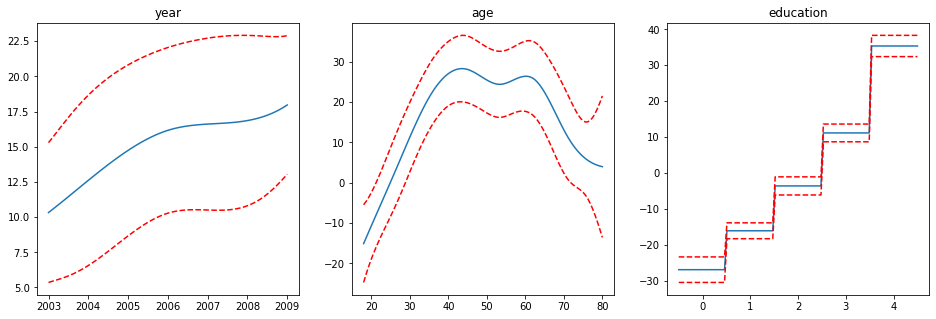

In [7]:
## plotting
fig, axs = plt.subplots(1,3, figsize=(16, 5))                   # create a figure with 3 subplots

titles = ['year', 'age', 'education']                           # titles for the subplots
for i, ax in enumerate(axs):                                    # iterate through the subplots
    XX = gam.generate_X_grid(term=i)                            # generate the grid for the ith term
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))                                 # plot the partial dependence of the ith term
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')   # plot the confidence interval
    ax.set_title(titles[i]);                                                                # set the title of the subplot
plt.show()

In [8]:
gam.summary()       # print the summary of the model
                    # You will find that the EDoF (effective degrees of freedom) is smaller than the number of splines, because we are using a penalty term. 

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      14.596
Link Function:                     IdentityLink Log Likelihood:                                -24116.5225
Number of Samples:                         3000 AIC:                                             48264.237
                                                AICc:                                           48264.4105
                                                GCV:                                             1246.7457
                                                Scale:                                            1235.832
                                                Pseudo R-Squared:                                   0.2935
Feature Function                  Lam

### Search for the best hyperparameters in the GAM model

Fitting the standard GAM used assumed default hyperparameters. We can use gridsearch to search for the best hyperparameter

In [9]:
## model
term = s(0,n_splines=30) + s(1,n_splines=30) + f(2) + te(0,1)     # create the terms. you can use for loop to construct many terms. te: interaction term
gam = LinearGAM(term)                     # create the LinearGAM object
gam.gridsearch(X, y)                      # grid search to find the best penalty, lam=np.logspace(-3, 3, 11) the default searching grid, so there are in total 11 choices. 
                                          # You can also specify the searching grid by yourself, lam=[0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
                                          # This penalization is for the whole model, not for each term. You can also specify the penalization for each term by yourself

y_pred = gam.predict(X)                   # predict the response
mse = mean_squared_error(y, y_pred)       # calculate the mean squared error for the training set
print("Mean Squared Error:", mse)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Mean Squared Error: 1223.3904838216579


In [10]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     29.2323
Link Function:                     IdentityLink Log Likelihood:                                -24115.5371
Number of Samples:                         3000 AIC:                                            48291.5387
                                                AICc:                                           48292.1748
                                                GCV:                                             1257.4644
                                                Scale:                                           1235.4286
                                                Pseudo R-Squared:                                   0.2972
Feature Function                  Lam

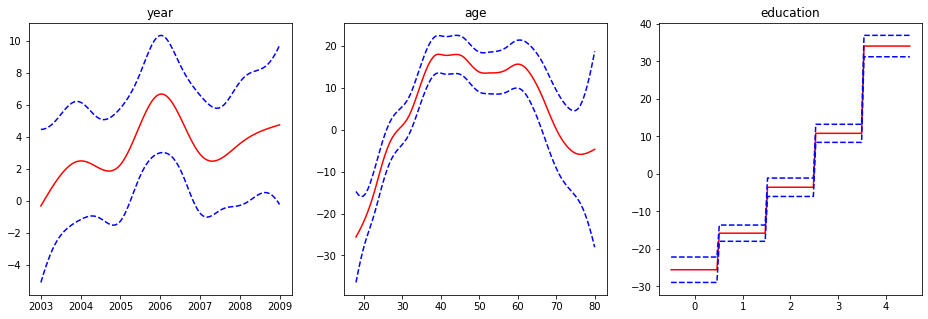

In [11]:
## plotting
fig, axs = plt.subplots(1,3, figsize=(16, 5))   # create a figure with 3 subplots

titles = ['year', 'age', 'education']           # titles for the subplots
for i, ax in enumerate(axs):                    # iterate through the subplots
    XX = gam.generate_X_grid(term=i)            # generate the grid for the ith term
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), color = 'r')                               # plot the partial dependence of the ith term
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], color='b', ls='--') # plot the confidence interval
    ax.set_title(titles[i]);                                                              # set the title of the subplot
plt.show()

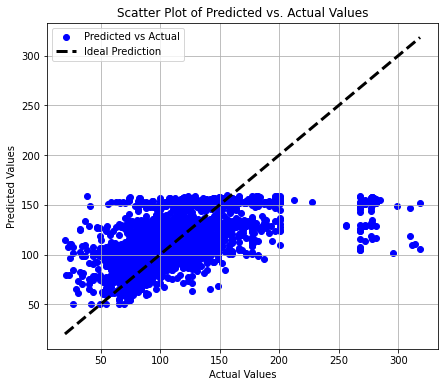

In [12]:
plt.figure(figsize=(7, 6))  # set the size of the figure
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')  # scatter plot
plt.title('Scatter Plot of Predicted vs. Actual Values')  # title
plt.xlabel('Actual Values')  # x-axis label
plt.ylabel('Predicted Values')  # y-axis label
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=3, label='Ideal Prediction')  # ideal prediction line
plt.legend()  # show legend
plt.grid(True)  # enable grid
plt.show()  # display the plot

### Important: We can also grid search different value for each term

In [13]:
from pygam import LinearGAM, s, f
import numpy as np

term = s(0, n_splines=30) + s(1, n_splines=30) + f(2)
gam = LinearGAM(term)

lam1 = np.logspace(-3, 3, 3)
lam2 = np.logspace(-3, 3, 3)
lam3 = np.logspace(-3, 3, 3)

# pass a list of per-term λ-arrays
gam.gridsearch(X, y, lam=[lam1, lam2, lam3])

print("Best λ:", gam.lam)


  0% (0 of 27) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (1 of 27) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00
  7% (2 of 27) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:02
 11% (3 of 27) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 14% (4 of 27) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (5 of 27) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (6 of 27) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (7 of 27) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 29% (8 of 27) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 33% (9 of 27) |########                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 37% (10 of 27) |########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 40% (11 of 27) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:01
 44% (12 of 27) |##########             

Best λ: [[1000.0], [1000.0], [1.0]]


In [14]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.7278
Link Function:                     IdentityLink Log Likelihood:                                -24116.1936
Number of Samples:                         3000 AIC:                                            48263.8428
                                                AICc:                                           48264.0192
                                                GCV:                                             1246.7082
                                                Scale:                                           1235.6963
                                                Pseudo R-Squared:                                   0.2936
Feature Function                  Lam

# LogisticGAM

In [27]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default  # import the default dataset

X, y = default(return_X_y=True)     # load the default dataset, return_X_y=True: returns the predictors and response

print('X\n', X)
print('y\n', y)

X
 [[0.00000000e+00 7.29526495e+02 4.43616251e+04]
 [1.00000000e+00 8.17180407e+02 1.21061347e+04]
 [0.00000000e+00 1.07354916e+03 3.17671389e+04]
 ...
 [0.00000000e+00 8.45411989e+02 5.86361570e+04]
 [0.00000000e+00 1.56900905e+03 3.66691124e+04]
 [1.00000000e+00 2.00922183e+02 1.68629523e+04]]
y
 [0. 0. 0. ... 0. 0. 0.]


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:07
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:04
 27% (3 of 11) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:03
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:03
 45% (5 of 11) |###########              | Elapsed Time: 0:00:02 ETA:   0:00:02
 54% (6 of 11) |#############            | Elapsed Time: 0:00:02 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


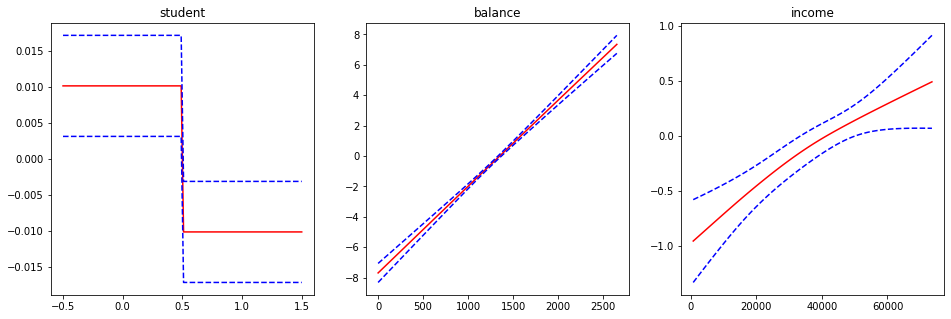

In [28]:
term = f(0) + s(1) + s(2)
gam = LogisticGAM(term)   # create the LogisticGAM object
gam.gridsearch(X, y)                    # grid search to find the best penalty

fig, axs = plt.subplots(1, 3, figsize=(16, 5))  # create a figure with 3 subplots
titles = ['student', 'balance', 'income']       # titles for the subplots

for i, ax in enumerate(axs):                    # iterate through the subplots
    XX = gam.generate_X_grid(term=i)            # generate the grid for the ith term
    pdep, confi = gam.partial_dependence(term=i, width=.95)  # calculate the partial dependence and confidence interval

    ax.plot(XX[:, i], pdep, c='r')                     # plot the partial dependence
    ax.plot(XX[:, i], confi, c='b', ls='--')    # plot the confidence interval
    ax.set_title(titles[i]);                    # set the title of the subplot
plt.show()

In [22]:
gam.accuracy(X, y) # calculate the accuracy of the model

0.9739

In [23]:
gam.summary()     # print the summary of the model

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8047
Link Function:                        LogitLink Log Likelihood:                                   -788.877
Number of Samples:                        10000 AIC:                                             1585.3634
                                                AICc:                                             1585.369
                                                UBRE:                                               2.1588
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4598
Feature Function                  Lam

# PoissonGAM

In [31]:
from pygam import PoissonGAM
from pygam.datasets import faithful    # import the faithful dataset

X, y = faithful(return_X_y=True)       # load the faithful dataset, return_X_y=True: returns the predictors and response

print('X shape\n', X.shape)
print('y shape\n', y.shape)

X shape
 (200, 1)
y shape
 (200,)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


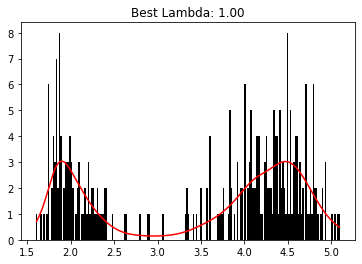

In [32]:
gam = PoissonGAM()                   # create the PoissonGAM object
gam.gridsearch(X, y)                 # grid search to find the best penalty

plt.hist(faithful(return_X_y=False)['eruptions'], bins=200, color='k'); # histogram of the eruptions
plt.plot(X, gam.predict(X), color='r')                                  # plot the prediction
plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));                # set the title
plt.show()

In [33]:
y_pred = gam.predict(X)                             # predict the response
mse = mean_squared_error(y, y_pred)                 # calculate the mean squared error
print("Mean Squared Error:", mse)

Mean Squared Error: 1.708918627328854


# Compare Logistic GAM with Logistic Regression and Probit Regression

In [34]:
# generate some random data. Same as Logistic regression
## logit function
def logistic(x):                # logit function
    return 1 / (1 + np.exp(-x))

# Create dataset
np.random.seed(5)   # set seed
n_sample = 100      # number of samples
a = 3.0             # coefficient
b = -9.0            # intercept

x = np.random.uniform(1, 5, size=n_sample) # generate random uniform data
x = np.sort(x)                             # sort the data

q = logistic(a * x + b)                    # calculate the probability
y = np.random.binomial(n=1, p=q)           # generate the response

In [35]:
# Run 3 models
from pygam import LogisticGAM, s, f
# 1. Logistic GAM
model_logistic_GAM = LogisticGAM(s(0,spline_order=3)).gridsearch(x.reshape(-1,1), y)
# 2. Logistic Regression
X, y = sm.add_constant(x), y
model_logistic = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
# 3. Probit Regression
model_probit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.probit())).fit()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


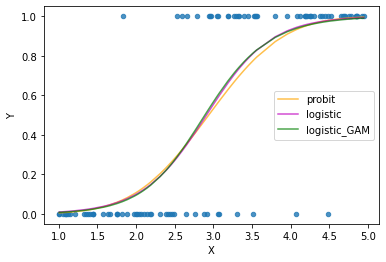

In [36]:
# Plot 3 models
y_pred_logistic_GAM = model_logistic_GAM.predict_proba(x)  # predict the response for logistic GAM
y_pred_probit = model_probit.predict(X)                    # predict the response for probit regression
y_pred_logistic = model_logistic.predict(X)                # predict the response for logistic regression

idx = x.argsort()       # sort the data for plotting
x_ord, y_pred_ord_probit, y_pred_ord_logistic = x[idx], y_pred_probit[idx], y_pred_logistic[idx]  # order the data
plt.plot(x_ord, y_pred_ord_probit, color='orange', alpha=0.7, label='probit')     # plot the probit regression
plt.plot(x_ord, y_pred_ord_logistic, color='m', alpha=0.7, label='logistic')      # plot the logistic regression
plt.plot(x_ord, y_pred_logistic_GAM, color='green', alpha=0.7, label='logistic_GAM')  # plot the logistic GAM

plt.scatter(x, y,  s=20, alpha=0.8)   # scatter plot
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

# A 3D graph of the logistic GAM that includes interaction terms

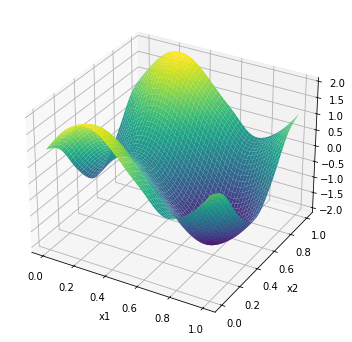

In [81]:
from pygam import LinearGAM, s, te
import numpy as np

# Sample data
np.random.seed(42)
X = np.random.rand(100, 2)  # let's assume two predictors x1, x2
y = np.sin(2 * np.pi * X[:, 0]) + np.cos(2 * np.pi * X[:, 1]) + np.random.randn(100) * 0.1  # some response

# Model with-out interaction
gam = LinearGAM(s(0) + s(1)).fit(X, y)
# Model with interaction
# gam = LinearGAM(s(0) + s(1) + te(0, 1)).fit(X, y)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generating a grid for the interaction plot
xi, xj = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
new_X = np.column_stack([xi.flatten(), xj.flatten()])

# Predicting on the new grid
preds = gam.predict(new_X)

# Reshape the predictions to fit the grid shape
Z = preds.reshape(xi.shape)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, xj, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('response')
plt.show()
